2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025FAFE0C400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step
2/

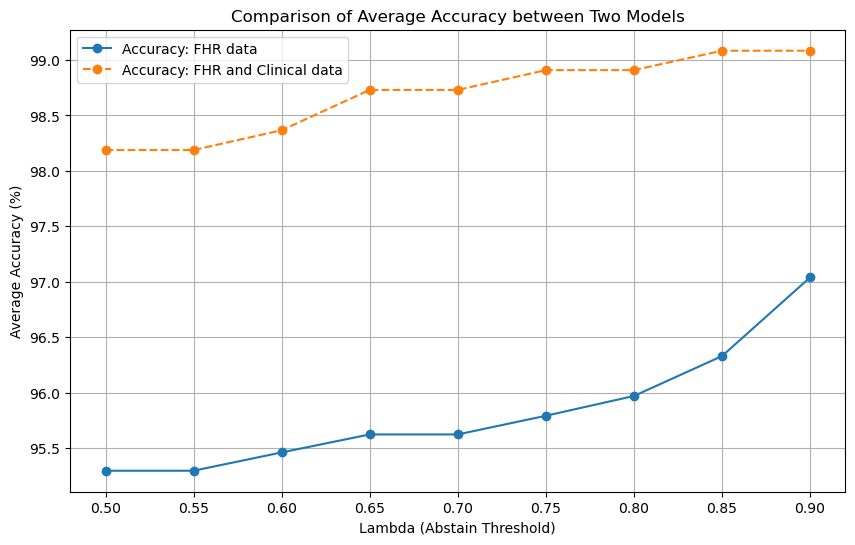

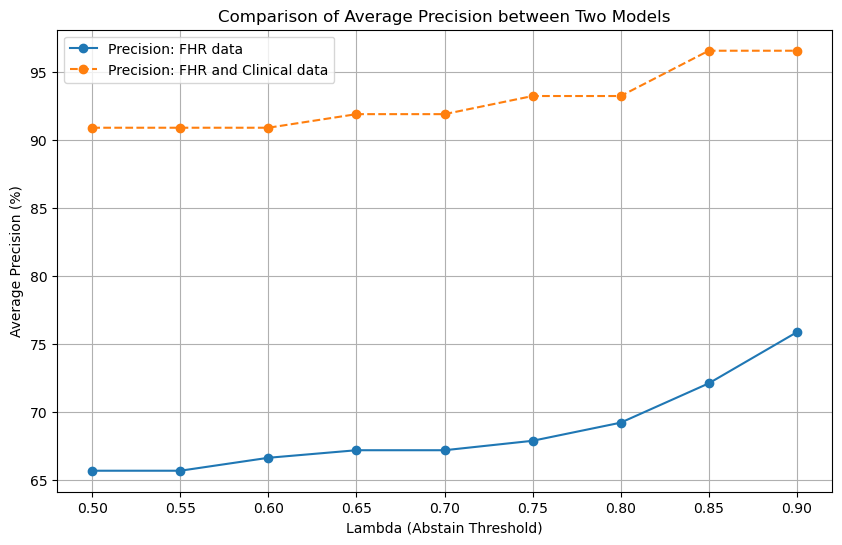

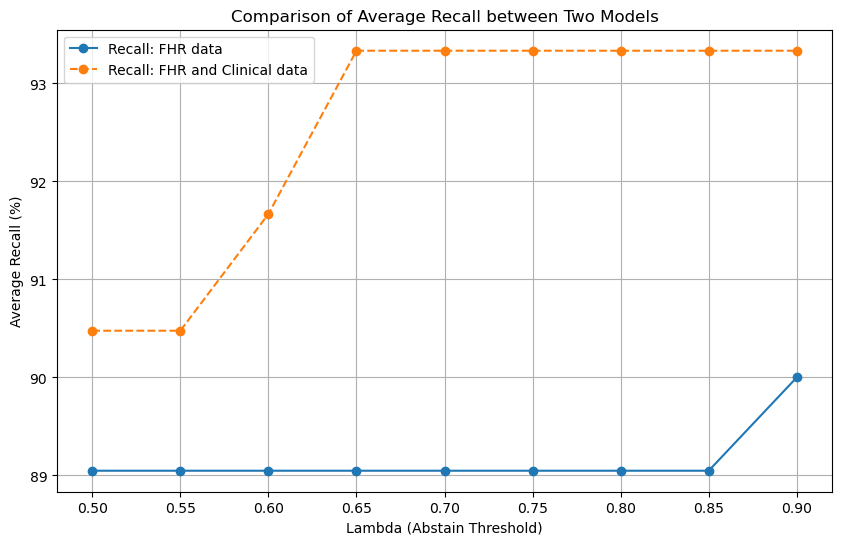

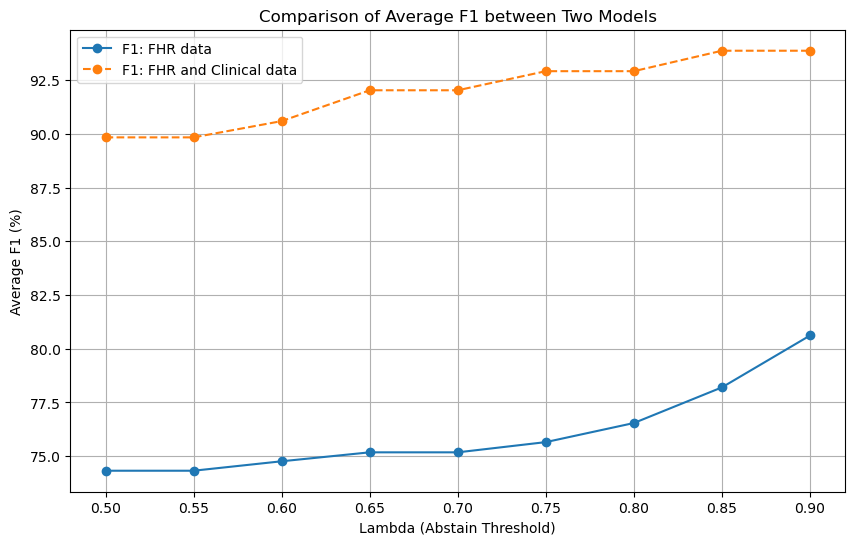

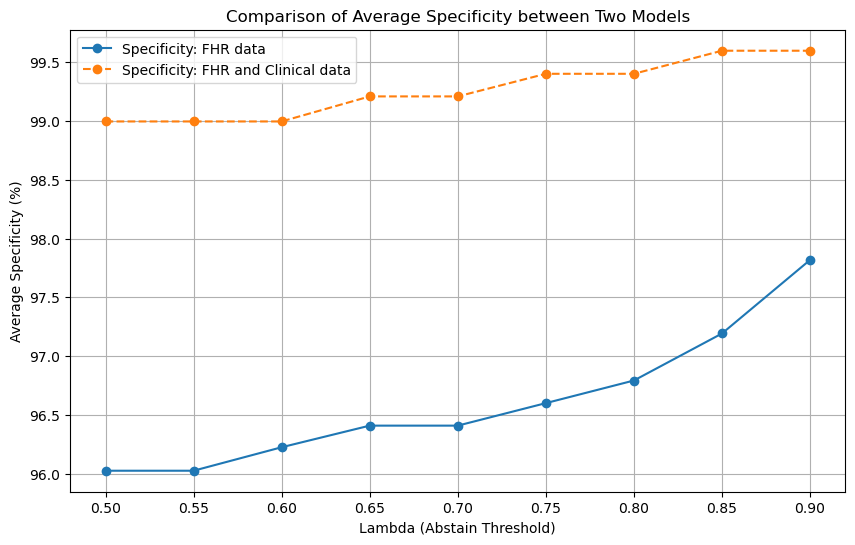

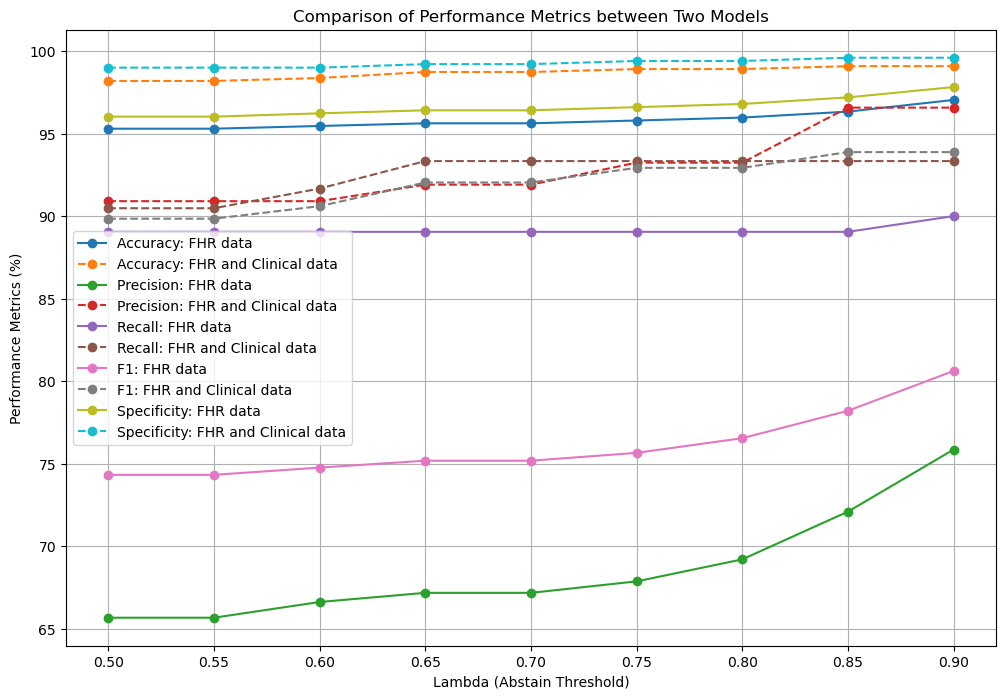

All comparison plots have been generated, saved as PDFs, and displayed in the Python environment.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# First Code Setup
data_path_1 = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter3_ClinicalData\Datasets\CTU-UHB\combined_FHR_data_resampled_with_minutes.csv"

# Second Code Setup
data_path_2 = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter3_ClinicalData\Datasets\CTU-UHB\combined_FHR_data_resampled_with_minutes_All_Features.csv"

# Directory to save PDFs
save_directory = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter3_ClinicalData\Git\Chapter3_ClinicalData\Results\PDF_diagrams"

# Helper function for shared metrics dictionary and classification
def classify_with_reject(probabilities, threshold, initial_fp_fn_indices):
    predictions = []
    abstain_instances = []
    for i, prob in enumerate(probabilities):
        if i not in initial_fp_fn_indices:
            if prob >= 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        else:
            if prob >= threshold:
                predictions.append(1)
            elif prob < 1 - threshold:
                predictions.append(0)
            else:
                predictions.append(-1)
                abstain_instances.append(i)
    return np.array(predictions), abstain_instances

# First Code Execution
df_1 = pd.read_csv(data_path_1)
df_1['label'] = df_1['label'].apply(lambda x: 0 if x == 1 else 1)
df_1.fillna(df_1.mean(), inplace=True)
X_time_series_1 = df_1.iloc[:, :-15].values
y_1 = df_1['label'].values
kf_1 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_dict_1 = {l: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'specificity': [], 'abstained_samples': []} for l in np.arange(0.5, 0.95, 0.05)}

fold_number_1 = 1
for train_index, test_index in kf_1.split(X_time_series_1):
    X_train_time_series, X_test_time_series = X_time_series_1[train_index], X_time_series_1[test_index]
    y_train_1, y_test_1 = y_1[train_index], y_1[test_index]

    # Standardize the features (mean=0, std=1)
    scaler_time_series_1 = StandardScaler()
    X_train_time_series = scaler_time_series_1.fit_transform(X_train_time_series)
    X_test_time_series = scaler_time_series_1.transform(X_test_time_series)

    # Reshape data for LSTM input (samples, timesteps, features)
    X_train_time_series = X_train_time_series.reshape((X_train_time_series.shape[0], X_train_time_series.shape[1], 1))
    X_test_time_series = X_test_time_series.reshape((X_test_time_series.shape[0], X_test_time_series.shape[1], 1))

    # Oversample the minority class using ADASYN on training data
    oversampler_1 = ADASYN(random_state=42)
    X_train_resampled_time_series, y_train_resampled_1 = oversampler_1.fit_resample(X_train_time_series.reshape(X_train_time_series.shape[0], -1), y_train_1)

    # Reshape resampled data
    X_train_resampled_time_series = X_train_resampled_time_series.reshape(-1, X_train_time_series.shape[1], 1)

    # Define model inputs
    input_time_series_1 = tf.keras.layers.Input(shape=(X_train_resampled_time_series.shape[1], X_train_resampled_time_series.shape[2]))

    # Build LSTM layers
    lstm1_1 = tf.keras.layers.LSTM(64, return_sequences=True)(input_time_series_1)
    lstm2_1 = tf.keras.layers.LSTM(64)(lstm1_1)
    flatten1_1 = tf.keras.layers.Flatten()(lstm2_1)

    # Pass to Dense layers
    dense_combined_1 = tf.keras.layers.Dense(128, activation='relu')(flatten1_1)
    dropout_combined_1 = tf.keras.layers.Dropout(0.5)(dense_combined_1)
    output_1 = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_combined_1)

    # Compile and create the model
    model_1 = tf.keras.models.Model(inputs=[input_time_series_1], outputs=output_1)
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model_1.fit(X_train_resampled_time_series, y_train_resampled_1, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Use the best model for predictions
    test_probabilities_1 = model_1.predict(X_test_time_series).flatten()

    # Initial classification with lambda=0.5
    initial_predictions_1 = (test_probabilities_1 >= 0.5).astype(int)
    initial_fp_fn_indices_1 = [i for i in range(len(initial_predictions_1)) if initial_predictions_1[i] != y_test_1[i]]

    for reject_threshold in np.arange(0.5, 0.95, 0.05):
        predictions_1, abstain_indices_1 = classify_with_reject(test_probabilities_1, reject_threshold, initial_fp_fn_indices_1)
        filtered_indices_1 = [i for i in range(len(predictions_1)) if predictions_1[i] != -1]
        y_test_filtered_1 = y_test_1[filtered_indices_1]
        predictions_filtered_1 = predictions_1[filtered_indices_1]

        if len(predictions_filtered_1) > 0:
            accuracy_1 = accuracy_score(y_test_filtered_1, predictions_filtered_1) * 100
            precision_1 = precision_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            recall_1 = recall_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            f1_1 = f1_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            specificity_1 = (confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 0] / (confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 0] + confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 1])) * 100
        else:
            accuracy_1 = precision_1 = recall_1 = f1_1 = specificity_1 = 0

        metrics_dict_1[reject_threshold]['accuracy'].append(accuracy_1)
        metrics_dict_1[reject_threshold]['precision'].append(precision_1)
        metrics_dict_1[reject_threshold]['recall'].append(recall_1)
        metrics_dict_1[reject_threshold]['f1'].append(f1_1)
        metrics_dict_1[reject_threshold]['specificity'].append(specificity_1)

# Second Code Execution
df_2 = pd.read_csv(data_path_2)
df_2['label'] = df_2['label'].apply(lambda x: 0 if x == 1 else 1)
df_2.fillna(df_2.mean(), inplace=True)
X_time_series_2 = df_2.iloc[:, :-15].values
X_additional_features_2 = df_2[['Age', 'Gravidity', 'Sex', 'Parity', 'Hypertension', 'Diabetes', 'Preeclampsia', 'Liq. praecox', 'Pyrexia', 'Meconium', 'Presentation', 'Induced', 'I.stage', 'NoProgress', 'II.stage']].values
X_2 = np.concatenate([X_time_series_2, X_additional_features_2], axis=1)
y_2 = df_2['label'].values
kf_2 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_dict_2 = {l: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'specificity': [], 'abstained_samples': []} for l in np.arange(0.5, 0.95, 0.05)}

fold_number_2 = 1
for train_index, test_index in kf_2.split(X_2):
    X_train_2, X_test_2 = X_2[train_index], X_2[test_index]
    y_train_2, y_test_2 = y_2[train_index], y_2[test_index]

    # Extract time series and additional features for training
    X_train_time_series_2 = X_train_2[:, :-15]
    X_train_additional_2 = X_train_2[:, -15:]
    X_test_time_series_2 = X_test_2[:, :-15]
    X_test_additional_2 = X_test_2[:, -15:]

    # Standardize the features (mean=0, std=1)
    scaler_time_series_2 = StandardScaler()
    X_train_time_series_2 = scaler_time_series_2.fit_transform(X_train_time_series_2)
    X_test_time_series_2 = scaler_time_series_2.transform(X_test_time_series_2)

    scaler_additional_2 = StandardScaler()
    X_train_additional_2 = scaler_additional_2.fit_transform(X_train_additional_2)
    X_test_additional_2 = scaler_additional_2.transform(X_test_additional_2)

    # Reshape data for LSTM input
    X_train_time_series_2 = X_train_time_series_2.reshape((X_train_time_series_2.shape[0], X_train_time_series_2.shape[1], 1))
    X_test_time_series_2 = X_test_time_series_2.reshape((X_test_time_series_2.shape[0], X_test_time_series_2.shape[1], 1))

    # Oversample the minority class using ADASYN on training data
    oversampler_2 = ADASYN(random_state=42)
    X_train_resampled_2, y_train_resampled_2 = oversampler_2.fit_resample(np.concatenate([X_train_time_series_2.reshape(X_train_time_series_2.shape[0], -1), X_train_additional_2], axis=1), y_train_2)

    # Reshape resampled data
    X_train_resampled_time_series_2 = X_train_resampled_2[:, :X_train_time_series_2.shape[1]].reshape(-1, X_train_time_series_2.shape[1], 1)
    X_train_resampled_additional_2 = X_train_resampled_2[:, X_train_time_series_2.shape[1]:]

    # Define model inputs
    input_time_series_2 = tf.keras.layers.Input(shape=(X_train_resampled_time_series_2.shape[1], X_train_resampled_time_series_2.shape[2]))
    input_additional_2 = tf.keras.layers.Input(shape=(X_train_resampled_additional_2.shape[1],))

    # Build LSTM layers
    lstm1_2 = tf.keras.layers.LSTM(64, return_sequences=True)(input_time_series_2)
    lstm2_2 = tf.keras.layers.LSTM(64)(lstm1_2)
    flatten1_2 = tf.keras.layers.Flatten()(lstm2_2)

    # Concatenate features and pass to Dense layers
    concatenated_features_2 = tf.keras.layers.concatenate([flatten1_2, input_additional_2])
    dense_combined_2 = tf.keras.layers.Dense(128, activation='relu')(concatenated_features_2)
    dropout_combined_2 = tf.keras.layers.Dropout(0.5)(dense_combined_2)
    output_2 = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_combined_2)

    # Compile and create the model
    model_2 = tf.keras.models.Model(inputs=[input_time_series_2, input_additional_2], outputs=output_2)
    model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model_2.fit([X_train_resampled_time_series_2, X_train_resampled_additional_2], y_train_resampled_2, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Use the best model for predictions
    test_probabilities_2 = model_2.predict([X_test_time_series_2, X_test_additional_2]).flatten()

    # Initial classification with lambda=0.5
    initial_predictions_2 = (test_probabilities_2 >= 0.5).astype(int)
    initial_fp_fn_indices_2 = [i for i in range(len(initial_predictions_2)) if initial_predictions_2[i] != y_test_2[i]]

    for reject_threshold in np.arange(0.5, 0.95, 0.05):
        predictions_2, abstain_indices_2 = classify_with_reject(test_probabilities_2, reject_threshold, initial_fp_fn_indices_2)
        filtered_indices_2 = [i for i in range(len(predictions_2)) if predictions_2[i] != -1]
        y_test_filtered_2 = y_test_2[filtered_indices_2]
        predictions_filtered_2 = predictions_2[filtered_indices_2]

        if len(predictions_filtered_2) > 0:
            accuracy_2 = accuracy_score(y_test_filtered_2, predictions_filtered_2) * 100
            precision_2 = precision_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            recall_2 = recall_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            f1_2 = f1_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            specificity_2 = (confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 0] / (confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 0] + confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 1])) * 100
        else:
            accuracy_2 = precision_2 = recall_2 = f1_2 = specificity_2 = 0

        metrics_dict_2[reject_threshold]['accuracy'].append(accuracy_2)
        metrics_dict_2[reject_threshold]['precision'].append(precision_2)
        metrics_dict_2[reject_threshold]['recall'].append(recall_2)
        metrics_dict_2[reject_threshold]['f1'].append(f1_2)
        metrics_dict_2[reject_threshold]['specificity'].append(specificity_2)

# Generate Comparison Plots for All Metrics
lambdas = np.arange(0.5, 0.95, 0.05)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'specificity']

# Save individual metric comparison plots and also display them
for metric in metrics:
    plt.figure(figsize=(10, 6))
    avg_metric_1 = [np.mean(metrics_dict_1[l][metric]) for l in lambdas]
    avg_metric_2 = [np.mean(metrics_dict_2[l][metric]) for l in lambdas]
    
    plt.plot(lambdas, avg_metric_1, marker='o', linestyle='-', label=f'{metric.capitalize()}: FHR data')
    plt.plot(lambdas, avg_metric_2, marker='o', linestyle='--', label=f'{metric.capitalize()}: FHR and Clinical data')
    
    plt.xlabel('Lambda (Abstain Threshold)')
    plt.ylabel(f'Average {metric.capitalize()} (%)')
    plt.title(f'Comparison of Average {metric.capitalize()} between Two Models')
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(f'{save_directory}/Comparison_{metric}.pdf')
    
    # Show the plot in the Python environment
    plt.show()

# Create Universal Figure with all metrics in one plot
plt.figure(figsize=(12, 8))

for metric in metrics:
    avg_metric_1 = [np.mean(metrics_dict_1[l][metric]) for l in lambdas]
    avg_metric_2 = [np.mean(metrics_dict_2[l][metric]) for l in lambdas]
    
    plt.plot(lambdas, avg_metric_1, marker='o', linestyle='-', label=f'{metric.capitalize()}: FHR data')
    plt.plot(lambdas, avg_metric_2, marker='o', linestyle='--', label=f'{metric.capitalize()}: FHR and Clinical data')

plt.xlabel('Lambda (Abstain Threshold)')
plt.ylabel('Performance Metrics (%)')
plt.title('Comparison of Performance Metrics between Two Models')
plt.legend()
plt.grid(True)

# Save the universal figure as a PDF
plt.savefig(f'{save_directory}/Universal_Performance_Metrics_Comparison.pdf')

# Show the universal figure in the Python environment
plt.show()

print("All comparison plots have been generated, saved as PDFs, and displayed in the Python environment.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000287FE3EF380> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
2/

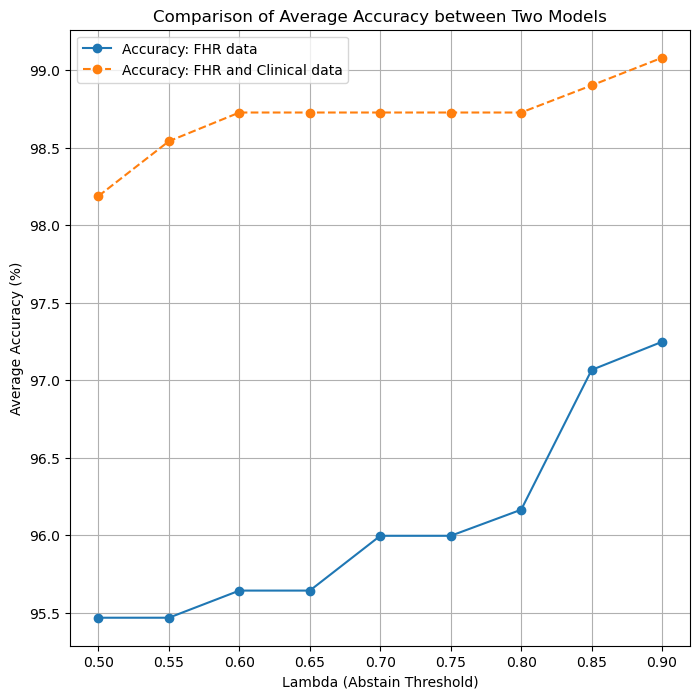

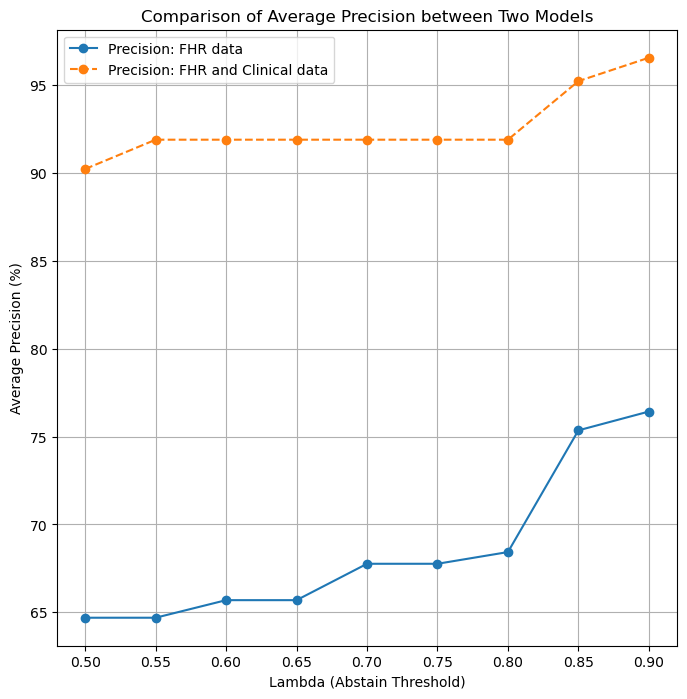

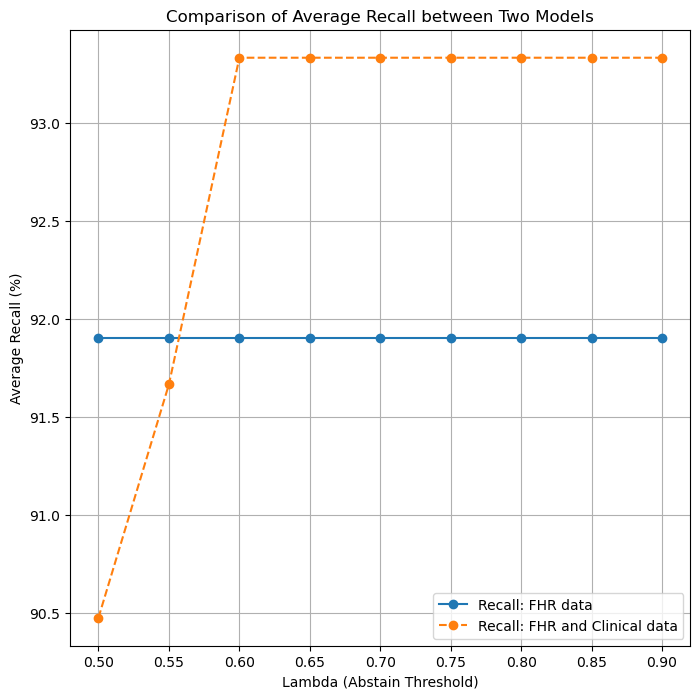

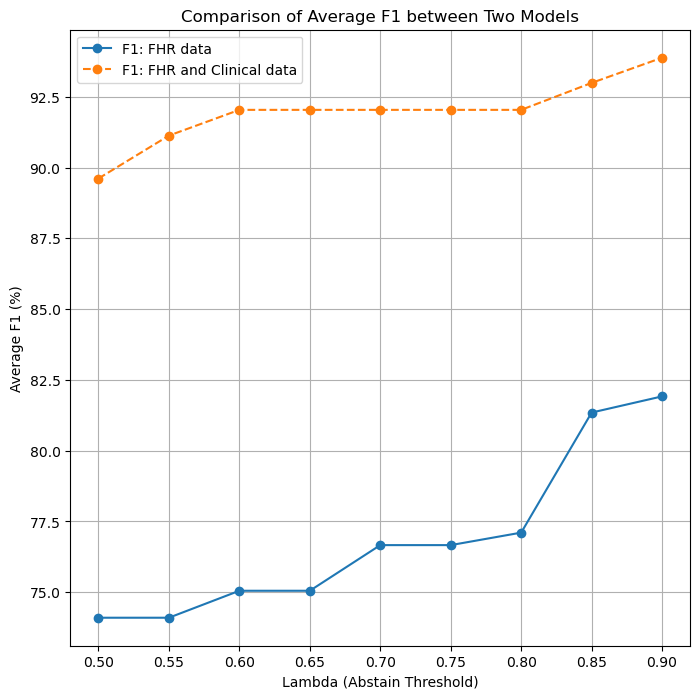

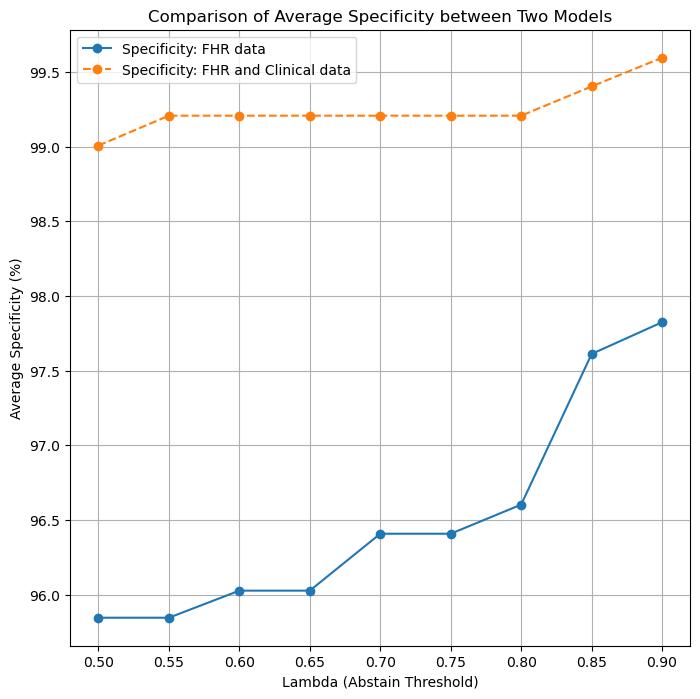

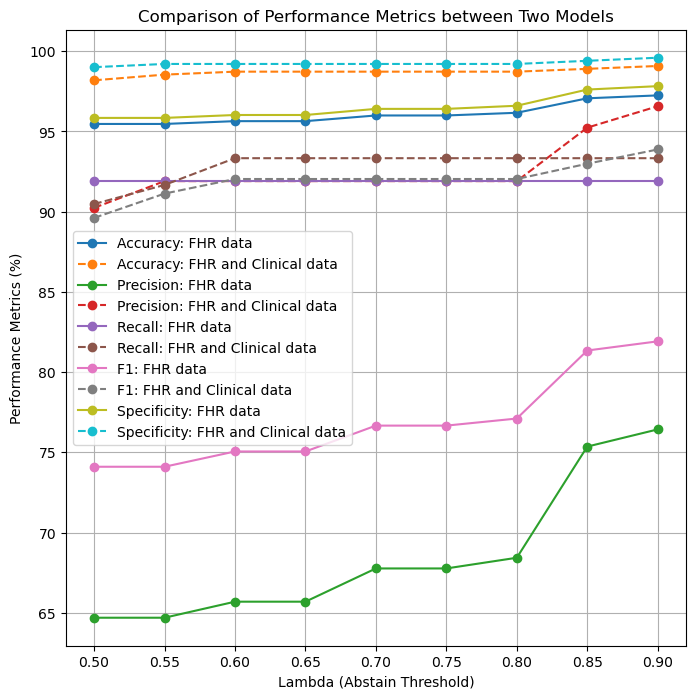

All comparison plots have been generated, saved as PDFs, and displayed in square size.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# First Code Setup
data_path_1 = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter3_ClinicalData\Datasets\CTU-UHB\combined_FHR_data_resampled_with_minutes.csv"

# Second Code Setup
data_path_2 = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter3_ClinicalData\Datasets\CTU-UHB\combined_FHR_data_resampled_with_minutes_All_Features.csv"

# Directory to save PDFs
save_directory = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter3_ClinicalData\Git\Chapter3_ClinicalData\Results\PDF_diagrams"

# Helper function for shared metrics dictionary and classification
def classify_with_reject(probabilities, threshold, initial_fp_fn_indices):
    predictions = []
    abstain_instances = []
    for i, prob in enumerate(probabilities):
        if i not in initial_fp_fn_indices:
            if prob >= 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        else:
            if prob >= threshold:
                predictions.append(1)
            elif prob < 1 - threshold:
                predictions.append(0)
            else:
                predictions.append(-1)
                abstain_instances.append(i)
    return np.array(predictions), abstain_instances

# First Code Execution
df_1 = pd.read_csv(data_path_1)
df_1['label'] = df_1['label'].apply(lambda x: 0 if x == 1 else 1)
df_1.fillna(df_1.mean(), inplace=True)
X_time_series_1 = df_1.iloc[:, :-15].values
y_1 = df_1['label'].values
kf_1 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_dict_1 = {l: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'specificity': [], 'abstained_samples': []} for l in np.arange(0.5, 0.95, 0.05)}

fold_number_1 = 1
for train_index, test_index in kf_1.split(X_time_series_1):
    X_train_time_series, X_test_time_series = X_time_series_1[train_index], X_time_series_1[test_index]
    y_train_1, y_test_1 = y_1[train_index], y_1[test_index]

    # Standardize the features (mean=0, std=1)
    scaler_time_series_1 = StandardScaler()
    X_train_time_series = scaler_time_series_1.fit_transform(X_train_time_series)
    X_test_time_series = scaler_time_series_1.transform(X_test_time_series)

    # Reshape data for LSTM input (samples, timesteps, features)
    X_train_time_series = X_train_time_series.reshape((X_train_time_series.shape[0], X_train_time_series.shape[1], 1))
    X_test_time_series = X_test_time_series.reshape((X_test_time_series.shape[0], X_test_time_series.shape[1], 1))

    # Oversample the minority class using ADASYN on training data
    oversampler_1 = ADASYN(random_state=42)
    X_train_resampled_time_series, y_train_resampled_1 = oversampler_1.fit_resample(X_train_time_series.reshape(X_train_time_series.shape[0], -1), y_train_1)

    # Reshape resampled data
    X_train_resampled_time_series = X_train_resampled_time_series.reshape(-1, X_train_time_series.shape[1], 1)

    # Define model inputs
    input_time_series_1 = tf.keras.layers.Input(shape=(X_train_resampled_time_series.shape[1], X_train_resampled_time_series.shape[2]))

    # Build LSTM layers
    lstm1_1 = tf.keras.layers.LSTM(64, return_sequences=True)(input_time_series_1)
    lstm2_1 = tf.keras.layers.LSTM(64)(lstm1_1)
    flatten1_1 = tf.keras.layers.Flatten()(lstm2_1)

    # Pass to Dense layers
    dense_combined_1 = tf.keras.layers.Dense(128, activation='relu')(flatten1_1)
    dropout_combined_1 = tf.keras.layers.Dropout(0.5)(dense_combined_1)
    output_1 = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_combined_1)

    # Compile and create the model
    model_1 = tf.keras.models.Model(inputs=[input_time_series_1], outputs=output_1)
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model_1.fit(X_train_resampled_time_series, y_train_resampled_1, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Use the best model for predictions
    test_probabilities_1 = model_1.predict(X_test_time_series).flatten()

    # Initial classification with lambda=0.5
    initial_predictions_1 = (test_probabilities_1 >= 0.5).astype(int)
    initial_fp_fn_indices_1 = [i for i in range(len(initial_predictions_1)) if initial_predictions_1[i] != y_test_1[i]]

    for reject_threshold in np.arange(0.5, 0.95, 0.05):
        predictions_1, abstain_indices_1 = classify_with_reject(test_probabilities_1, reject_threshold, initial_fp_fn_indices_1)
        filtered_indices_1 = [i for i in range(len(predictions_1)) if predictions_1[i] != -1]
        y_test_filtered_1 = y_test_1[filtered_indices_1]
        predictions_filtered_1 = predictions_1[filtered_indices_1]

        if len(predictions_filtered_1) > 0:
            accuracy_1 = accuracy_score(y_test_filtered_1, predictions_filtered_1) * 100
            precision_1 = precision_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            recall_1 = recall_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            f1_1 = f1_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            specificity_1 = (confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 0] / (confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 0] + confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 1])) * 100
        else:
            accuracy_1 = precision_1 = recall_1 = f1_1 = specificity_1 = 0

        metrics_dict_1[reject_threshold]['accuracy'].append(accuracy_1)
        metrics_dict_1[reject_threshold]['precision'].append(precision_1)
        metrics_dict_1[reject_threshold]['recall'].append(recall_1)
        metrics_dict_1[reject_threshold]['f1'].append(f1_1)
        metrics_dict_1[reject_threshold]['specificity'].append(specificity_1)

# Second Code Execution
df_2 = pd.read_csv(data_path_2)
df_2['label'] = df_2['label'].apply(lambda x: 0 if x == 1 else 1)
df_2.fillna(df_2.mean(), inplace=True)
X_time_series_2 = df_2.iloc[:, :-15].values
X_additional_features_2 = df_2[['Age', 'Gravidity', 'Sex', 'Parity', 'Hypertension', 'Diabetes', 'Preeclampsia', 'Liq. praecox', 'Pyrexia', 'Meconium', 'Presentation', 'Induced', 'I.stage', 'NoProgress', 'II.stage']].values
X_2 = np.concatenate([X_time_series_2, X_additional_features_2], axis=1)
y_2 = df_2['label'].values
kf_2 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_dict_2 = {l: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'specificity': [], 'abstained_samples': []} for l in np.arange(0.5, 0.95, 0.05)}

fold_number_2 = 1
for train_index, test_index in kf_2.split(X_2):
    X_train_2, X_test_2 = X_2[train_index], X_2[test_index]
    y_train_2, y_test_2 = y_2[train_index], y_2[test_index]

    # Extract time series and additional features for training
    X_train_time_series_2 = X_train_2[:, :-15]
    X_train_additional_2 = X_train_2[:, -15:]
    X_test_time_series_2 = X_test_2[:, :-15]
    X_test_additional_2 = X_test_2[:, -15:]

    # Standardize the features (mean=0, std=1)
    scaler_time_series_2 = StandardScaler()
    X_train_time_series_2 = scaler_time_series_2.fit_transform(X_train_time_series_2)
    X_test_time_series_2 = scaler_time_series_2.transform(X_test_time_series_2)

    scaler_additional_2 = StandardScaler()
    X_train_additional_2 = scaler_additional_2.fit_transform(X_train_additional_2)
    X_test_additional_2 = scaler_additional_2.transform(X_test_additional_2)

    # Reshape data for LSTM input
    X_train_time_series_2 = X_train_time_series_2.reshape((X_train_time_series_2.shape[0], X_train_time_series_2.shape[1], 1))
    X_test_time_series_2 = X_test_time_series_2.reshape((X_test_time_series_2.shape[0], X_test_time_series_2.shape[1], 1))

    # Oversample the minority class using ADASYN on training data
    oversampler_2 = ADASYN(random_state=42)
    X_train_resampled_2, y_train_resampled_2 = oversampler_2.fit_resample(np.concatenate([X_train_time_series_2.reshape(X_train_time_series_2.shape[0], -1), X_train_additional_2], axis=1), y_train_2)

    # Reshape resampled data
    X_train_resampled_time_series_2 = X_train_resampled_2[:, :X_train_time_series_2.shape[1]].reshape(-1, X_train_time_series_2.shape[1], 1)
    X_train_resampled_additional_2 = X_train_resampled_2[:, X_train_time_series_2.shape[1]:]

    # Define model inputs
    input_time_series_2 = tf.keras.layers.Input(shape=(X_train_resampled_time_series_2.shape[1], X_train_resampled_time_series_2.shape[2]))
    input_additional_2 = tf.keras.layers.Input(shape=(X_train_resampled_additional_2.shape[1],))

    # Build LSTM layers
    lstm1_2 = tf.keras.layers.LSTM(64, return_sequences=True)(input_time_series_2)
    lstm2_2 = tf.keras.layers.LSTM(64)(lstm1_2)
    flatten1_2 = tf.keras.layers.Flatten()(lstm2_2)

    # Concatenate features and pass to Dense layers
    concatenated_features_2 = tf.keras.layers.concatenate([flatten1_2, input_additional_2])
    dense_combined_2 = tf.keras.layers.Dense(128, activation='relu')(concatenated_features_2)
    dropout_combined_2 = tf.keras.layers.Dropout(0.5)(dense_combined_2)
    output_2 = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_combined_2)

    # Compile and create the model
    model_2 = tf.keras.models.Model(inputs=[input_time_series_2, input_additional_2], outputs=output_2)
    model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model_2.fit([X_train_resampled_time_series_2, X_train_resampled_additional_2], y_train_resampled_2, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Use the best model for predictions
    test_probabilities_2 = model_2.predict([X_test_time_series_2, X_test_additional_2]).flatten()

    # Initial classification with lambda=0.5
    initial_predictions_2 = (test_probabilities_2 >= 0.5).astype(int)
    initial_fp_fn_indices_2 = [i for i in range(len(initial_predictions_2)) if initial_predictions_2[i] != y_test_2[i]]

    for reject_threshold in np.arange(0.5, 0.95, 0.05):
        predictions_2, abstain_indices_2 = classify_with_reject(test_probabilities_2, reject_threshold, initial_fp_fn_indices_2)
        filtered_indices_2 = [i for i in range(len(predictions_2)) if predictions_2[i] != -1]
        y_test_filtered_2 = y_test_2[filtered_indices_2]
        predictions_filtered_2 = predictions_2[filtered_indices_2]

        if len(predictions_filtered_2) > 0:
            accuracy_2 = accuracy_score(y_test_filtered_2, predictions_filtered_2) * 100
            precision_2 = precision_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            recall_2 = recall_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            f1_2 = f1_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            specificity_2 = (confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 0] / (confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 0] + confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 1])) * 100
        else:
            accuracy_2 = precision_2 = recall_2 = f1_2 = specificity_2 = 0

        metrics_dict_2[reject_threshold]['accuracy'].append(accuracy_2)
        metrics_dict_2[reject_threshold]['precision'].append(precision_2)
        metrics_dict_2[reject_threshold]['recall'].append(recall_2)
        metrics_dict_2[reject_threshold]['f1'].append(f1_2)
        metrics_dict_2[reject_threshold]['specificity'].append(specificity_2)

# Generate Comparison Plots for All Metrics
lambdas = np.arange(0.5, 0.95, 0.05)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'specificity']

# Save individual metric comparison plots and also display them in square size
for metric in metrics:
    plt.figure(figsize=(8, 8))  # Set square size
    avg_metric_1 = [np.mean(metrics_dict_1[l][metric]) for l in lambdas]
    avg_metric_2 = [np.mean(metrics_dict_2[l][metric]) for l in lambdas]
    
    plt.plot(lambdas, avg_metric_1, marker='o', linestyle='-', label=f'{metric.capitalize()}: FHR data')
    plt.plot(lambdas, avg_metric_2, marker='o', linestyle='--', label=f'{metric.capitalize()}: FHR and Clinical data')
    
    plt.xlabel('Lambda (Abstain Threshold)')
    plt.ylabel(f'Average {metric.capitalize()} (%)')
    plt.title(f'Comparison of Average {metric.capitalize()} between Two Models')
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(f'{save_directory}/Comparison_{metric}.pdf')
    
    # Show the plot in the Python environment
    plt.show()

# Create Universal Figure with all metrics in one plot (square size)
plt.figure(figsize=(8, 8))  # Set square size

for metric in metrics:
    avg_metric_1 = [np.mean(metrics_dict_1[l][metric]) for l in lambdas]
    avg_metric_2 = [np.mean(metrics_dict_2[l][metric]) for l in lambdas]
    
    plt.plot(lambdas, avg_metric_1, marker='o', linestyle='-', label=f'{metric.capitalize()}: FHR data')
    plt.plot(lambdas, avg_metric_2, marker='o', linestyle='--', label=f'{metric.capitalize()}: FHR and Clinical data')

plt.xlabel('Lambda (Abstain Threshold)')
plt.ylabel('Performance Metrics (%)')
plt.title('Comparison of Performance Metrics between Two Models')
plt.legend()
plt.grid(True)

# Save the universal figure as a PDF
plt.savefig(f'{save_directory}/Universal_Performance_Metrics_Comparison.pdf')

# Show the universal figure in the Python environment
plt.show()

print("All comparison plots have been generated, saved as PDFs, and displayed in square size.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000272494A2980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/

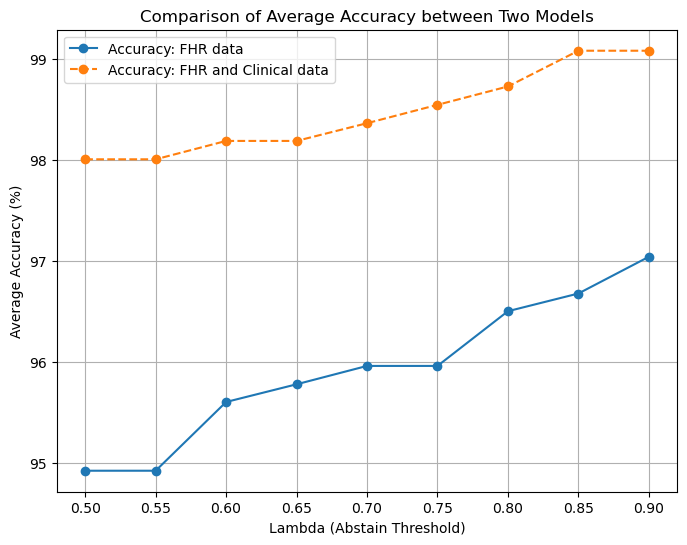

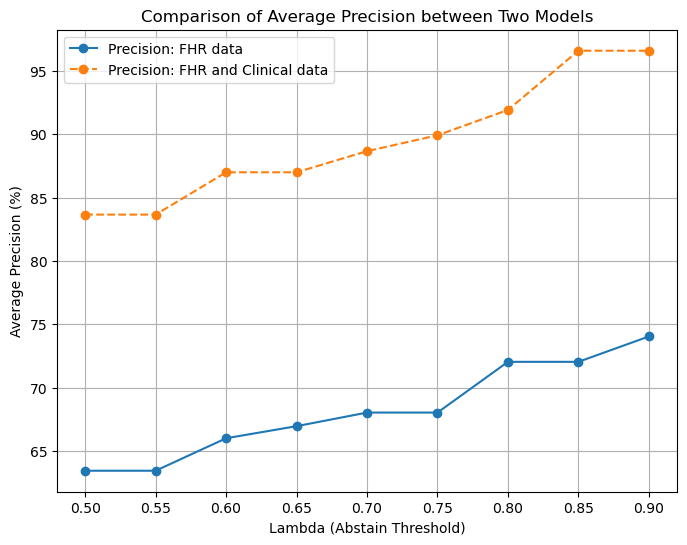

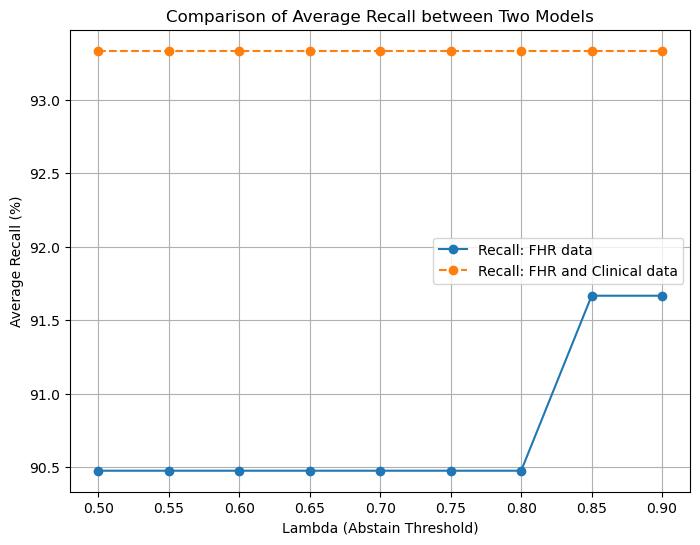

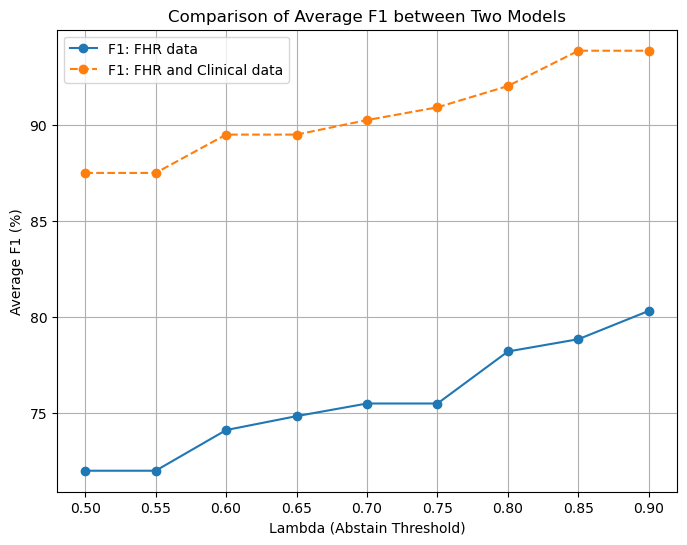

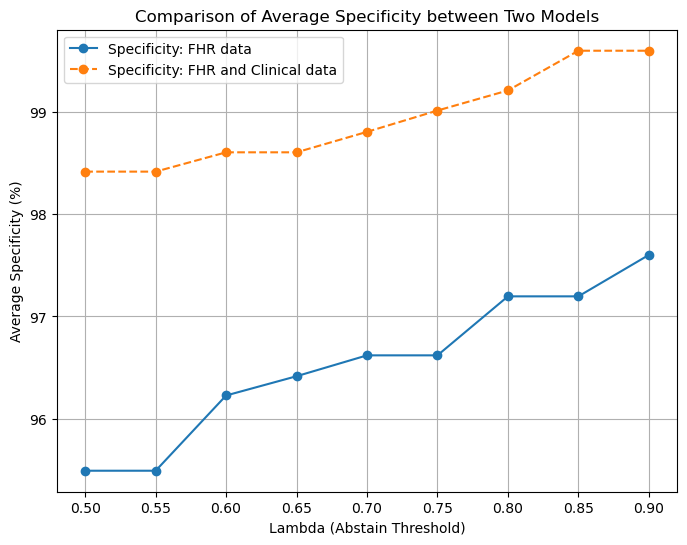

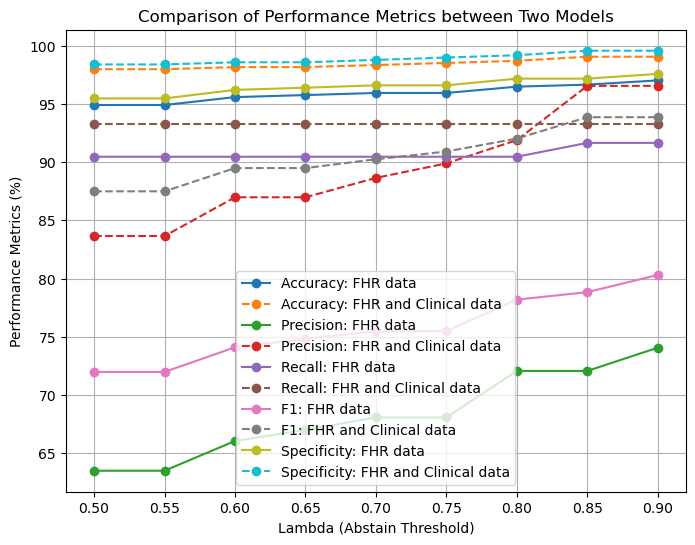

All comparison plots have been generated, saved as PDFs, and displayed in square size.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# First Code Setup
data_path_1 = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter4_DM\Datasets\CTU-UHB\combined_FHR_data_resampled_with_minutes.csv"

# Second Code Setup
data_path_2 = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter4_DM\Datasets\CTU-UHB\combined_FHR_data_resampled_with_minutes_All_Features.csv"

# Directory to save PDFs
save_directory = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\Chapters\Chapter4_DM\Git\Chapter3_ClinicalData\Results\PDF_diagrams"

# Helper function for shared metrics dictionary and classification
def classify_with_reject(probabilities, threshold, initial_fp_fn_indices):
    predictions = []
    abstain_instances = []
    for i, prob in enumerate(probabilities):
        if i not in initial_fp_fn_indices:
            if prob >= 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        else:
            if prob >= threshold:
                predictions.append(1)
            elif prob < 1 - threshold:
                predictions.append(0)
            else:
                predictions.append(-1)
                abstain_instances.append(i)
    return np.array(predictions), abstain_instances

# First Code Execution
df_1 = pd.read_csv(data_path_1)
df_1['label'] = df_1['label'].apply(lambda x: 0 if x == 1 else 1)
df_1.fillna(df_1.mean(), inplace=True)
X_time_series_1 = df_1.iloc[:, :-15].values
y_1 = df_1['label'].values
kf_1 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_dict_1 = {l: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'specificity': [], 'abstained_samples': []} for l in np.arange(0.5, 0.95, 0.05)}

fold_number_1 = 1
for train_index, test_index in kf_1.split(X_time_series_1):
    X_train_time_series, X_test_time_series = X_time_series_1[train_index], X_time_series_1[test_index]
    y_train_1, y_test_1 = y_1[train_index], y_1[test_index]

    # Standardize the features (mean=0, std=1)
    scaler_time_series_1 = StandardScaler()
    X_train_time_series = scaler_time_series_1.fit_transform(X_train_time_series)
    X_test_time_series = scaler_time_series_1.transform(X_test_time_series)

    # Reshape data for LSTM input (samples, timesteps, features)
    X_train_time_series = X_train_time_series.reshape((X_train_time_series.shape[0], X_train_time_series.shape[1], 1))
    X_test_time_series = X_test_time_series.reshape((X_test_time_series.shape[0], X_test_time_series.shape[1], 1))

    # Oversample the minority class using ADASYN on training data
    oversampler_1 = ADASYN(random_state=42)
    X_train_resampled_time_series, y_train_resampled_1 = oversampler_1.fit_resample(X_train_time_series.reshape(X_train_time_series.shape[0], -1), y_train_1)

    # Reshape resampled data
    X_train_resampled_time_series = X_train_resampled_time_series.reshape(-1, X_train_time_series.shape[1], 1)

    # Define model inputs
    input_time_series_1 = tf.keras.layers.Input(shape=(X_train_resampled_time_series.shape[1], X_train_resampled_time_series.shape[2]))

    # Build LSTM layers
    lstm1_1 = tf.keras.layers.LSTM(64, return_sequences=True)(input_time_series_1)
    lstm2_1 = tf.keras.layers.LSTM(64)(lstm1_1)
    flatten1_1 = tf.keras.layers.Flatten()(lstm2_1)

    # Pass to Dense layers
    dense_combined_1 = tf.keras.layers.Dense(128, activation='relu')(flatten1_1)
    dropout_combined_1 = tf.keras.layers.Dropout(0.5)(dense_combined_1)
    output_1 = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_combined_1)

    # Compile and create the model
    model_1 = tf.keras.models.Model(inputs=[input_time_series_1], outputs=output_1)
    model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model_1.fit(X_train_resampled_time_series, y_train_resampled_1, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Use the best model for predictions
    test_probabilities_1 = model_1.predict(X_test_time_series).flatten()

    # Initial classification with lambda=0.5
    initial_predictions_1 = (test_probabilities_1 >= 0.5).astype(int)
    initial_fp_fn_indices_1 = [i for i in range(len(initial_predictions_1)) if initial_predictions_1[i] != y_test_1[i]]

    for reject_threshold in np.arange(0.5, 0.95, 0.05):
        predictions_1, abstain_indices_1 = classify_with_reject(test_probabilities_1, reject_threshold, initial_fp_fn_indices_1)
        filtered_indices_1 = [i for i in range(len(predictions_1)) if predictions_1[i] != -1]
        y_test_filtered_1 = y_test_1[filtered_indices_1]
        predictions_filtered_1 = predictions_1[filtered_indices_1]

        if len(predictions_filtered_1) > 0:
            accuracy_1 = accuracy_score(y_test_filtered_1, predictions_filtered_1) * 100
            precision_1 = precision_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            recall_1 = recall_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            f1_1 = f1_score(y_test_filtered_1, predictions_filtered_1, zero_division=0) * 100
            specificity_1 = (confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 0] / (confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 0] + confusion_matrix(y_test_filtered_1, predictions_filtered_1, labels=[0, 1])[0, 1])) * 100
        else:
            accuracy_1 = precision_1 = recall_1 = f1_1 = specificity_1 = 0

        metrics_dict_1[reject_threshold]['accuracy'].append(accuracy_1)
        metrics_dict_1[reject_threshold]['precision'].append(precision_1)
        metrics_dict_1[reject_threshold]['recall'].append(recall_1)
        metrics_dict_1[reject_threshold]['f1'].append(f1_1)
        metrics_dict_1[reject_threshold]['specificity'].append(specificity_1)

# Second Code Execution
df_2 = pd.read_csv(data_path_2)
df_2['label'] = df_2['label'].apply(lambda x: 0 if x == 1 else 1)
df_2.fillna(df_2.mean(), inplace=True)
X_time_series_2 = df_2.iloc[:, :-15].values
X_additional_features_2 = df_2[['Age', 'Gravidity', 'Sex', 'Parity', 'Hypertension', 'Diabetes', 'Preeclampsia', 'Liq. praecox', 'Pyrexia', 'Meconium', 'Presentation', 'Induced', 'I.stage', 'NoProgress', 'II.stage']].values
X_2 = np.concatenate([X_time_series_2, X_additional_features_2], axis=1)
y_2 = df_2['label'].values
kf_2 = KFold(n_splits=10, shuffle=True, random_state=42)
metrics_dict_2 = {l: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'specificity': [], 'abstained_samples': []} for l in np.arange(0.5, 0.95, 0.05)}

fold_number_2 = 1
for train_index, test_index in kf_2.split(X_2):
    X_train_2, X_test_2 = X_2[train_index], X_2[test_index]
    y_train_2, y_test_2 = y_2[train_index], y_2[test_index]

    # Extract time series and additional features for training
    X_train_time_series_2 = X_train_2[:, :-15]
    X_train_additional_2 = X_train_2[:, -15:]
    X_test_time_series_2 = X_test_2[:, :-15]
    X_test_additional_2 = X_test_2[:, -15:]

    # Standardize the features (mean=0, std=1)
    scaler_time_series_2 = StandardScaler()
    X_train_time_series_2 = scaler_time_series_2.fit_transform(X_train_time_series_2)
    X_test_time_series_2 = scaler_time_series_2.transform(X_test_time_series_2)

    scaler_additional_2 = StandardScaler()
    X_train_additional_2 = scaler_additional_2.fit_transform(X_train_additional_2)
    X_test_additional_2 = scaler_additional_2.transform(X_test_additional_2)

    # Reshape data for LSTM input
    X_train_time_series_2 = X_train_time_series_2.reshape((X_train_time_series_2.shape[0], X_train_time_series_2.shape[1], 1))
    X_test_time_series_2 = X_test_time_series_2.reshape((X_test_time_series_2.shape[0], X_test_time_series_2.shape[1], 1))

    # Oversample the minority class using ADASYN on training data
    oversampler_2 = ADASYN(random_state=42)
    X_train_resampled_2, y_train_resampled_2 = oversampler_2.fit_resample(np.concatenate([X_train_time_series_2.reshape(X_train_time_series_2.shape[0], -1), X_train_additional_2], axis=1), y_train_2)

    # Reshape resampled data
    X_train_resampled_time_series_2 = X_train_resampled_2[:, :X_train_time_series_2.shape[1]].reshape(-1, X_train_time_series_2.shape[1], 1)
    X_train_resampled_additional_2 = X_train_resampled_2[:, X_train_time_series_2.shape[1]:]

    # Define model inputs
    input_time_series_2 = tf.keras.layers.Input(shape=(X_train_resampled_time_series_2.shape[1], X_train_resampled_time_series_2.shape[2]))
    input_additional_2 = tf.keras.layers.Input(shape=(X_train_resampled_additional_2.shape[1],))

    # Build LSTM layers
    lstm1_2 = tf.keras.layers.LSTM(64, return_sequences=True)(input_time_series_2)
    lstm2_2 = tf.keras.layers.LSTM(64)(lstm1_2)
    flatten1_2 = tf.keras.layers.Flatten()(lstm2_2)

    # Concatenate features and pass to Dense layers
    concatenated_features_2 = tf.keras.layers.concatenate([flatten1_2, input_additional_2])
    dense_combined_2 = tf.keras.layers.Dense(128, activation='relu')(concatenated_features_2)
    dropout_combined_2 = tf.keras.layers.Dropout(0.5)(dense_combined_2)
    output_2 = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_combined_2)

    # Compile and create the model
    model_2 = tf.keras.models.Model(inputs=[input_time_series_2, input_additional_2], outputs=output_2)
    model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model_2.fit([X_train_resampled_time_series_2, X_train_resampled_additional_2], y_train_resampled_2, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Use the best model for predictions
    test_probabilities_2 = model_2.predict([X_test_time_series_2, X_test_additional_2]).flatten()

    # Initial classification with lambda=0.5
    initial_predictions_2 = (test_probabilities_2 >= 0.5).astype(int)
    initial_fp_fn_indices_2 = [i for i in range(len(initial_predictions_2)) if initial_predictions_2[i] != y_test_2[i]]

    for reject_threshold in np.arange(0.5, 0.95, 0.05):
        predictions_2, abstain_indices_2 = classify_with_reject(test_probabilities_2, reject_threshold, initial_fp_fn_indices_2)
        filtered_indices_2 = [i for i in range(len(predictions_2)) if predictions_2[i] != -1]
        y_test_filtered_2 = y_test_2[filtered_indices_2]
        predictions_filtered_2 = predictions_2[filtered_indices_2]

        if len(predictions_filtered_2) > 0:
            accuracy_2 = accuracy_score(y_test_filtered_2, predictions_filtered_2) * 100
            precision_2 = precision_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            recall_2 = recall_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            f1_2 = f1_score(y_test_filtered_2, predictions_filtered_2, zero_division=0) * 100
            specificity_2 = (confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 0] / (confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 0] + confusion_matrix(y_test_filtered_2, predictions_filtered_2, labels=[0, 1])[0, 1])) * 100
        else:
            accuracy_2 = precision_2 = recall_2 = f1_2 = specificity_2 = 0

        metrics_dict_2[reject_threshold]['accuracy'].append(accuracy_2)
        metrics_dict_2[reject_threshold]['precision'].append(precision_2)
        metrics_dict_2[reject_threshold]['recall'].append(recall_2)
        metrics_dict_2[reject_threshold]['f1'].append(f1_2)
        metrics_dict_2[reject_threshold]['specificity'].append(specificity_2)

# Generate Comparison Plots for All Metrics
lambdas = np.arange(0.5, 0.95, 0.05)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'specificity']

# Save individual metric comparison plots and also display them in square size
for metric in metrics:
    plt.figure(figsize=(8, 6))  # Set square size
    avg_metric_1 = [np.mean(metrics_dict_1[l][metric]) for l in lambdas]
    avg_metric_2 = [np.mean(metrics_dict_2[l][metric]) for l in lambdas]
    
    plt.plot(lambdas, avg_metric_1, marker='o', linestyle='-', label=f'{metric.capitalize()}: FHR data')
    plt.plot(lambdas, avg_metric_2, marker='o', linestyle='--', label=f'{metric.capitalize()}: FHR and Clinical data')
    
    plt.xlabel('Lambda (Abstain Threshold)')
    plt.ylabel(f'Average {metric.capitalize()} (%)')
    plt.title(f'Comparison of Average {metric.capitalize()} between Two Models')
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(f'{save_directory}/Comparison_{metric}.pdf')
    
    # Show the plot in the Python environment
    plt.show()

# Create Universal Figure with all metrics in one plot (square size)
plt.figure(figsize=(8, 6))  # Set square size

for metric in metrics:
    avg_metric_1 = [np.mean(metrics_dict_1[l][metric]) for l in lambdas]
    avg_metric_2 = [np.mean(metrics_dict_2[l][metric]) for l in lambdas]
    
    plt.plot(lambdas, avg_metric_1, marker='o', linestyle='-', label=f'{metric.capitalize()}: FHR data')
    plt.plot(lambdas, avg_metric_2, marker='o', linestyle='--', label=f'{metric.capitalize()}: FHR and Clinical data')

plt.xlabel('Lambda (Abstain Threshold)')
plt.ylabel('Performance Metrics (%)')
plt.title('Comparison of Performance Metrics between Two Models')
plt.legend()
plt.grid(True)

# Save the universal figure as a PDF
plt.savefig(f'{save_directory}/Universal_Performance_Metrics_Comparison.pdf')

# Show the universal figure in the Python environment
plt.show()

print("All comparison plots have been generated, saved as PDFs, and displayed in square size.")
